In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, BertTokenizer, BertForSequenceClassification
from peft import PeftModel, PeftConfig, PeftModelForSequenceClassification, get_peft_model, LoraConfig
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import torch
import pickle
from defense import krum, multi_krum, bulyan, detect_outliers_from_weights, trimmed_mean
from defense_utils import *

In [2]:
with open('training_log.pkl', 'rb') as f:
    log = pickle.load(f)

/Users/vblack/opt/miniconda3/envs/fedllm/lib/python3.8/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [3]:
device = 'mps'
lora_config = LoraConfig(
        r=4,                       # Rank of the low-rank matrix
        lora_alpha=32,             # Scaling factor for the LoRA updates
        # target_modules=["query", "key", "value"],  # Apply LoRA to the attention layers
        lora_dropout=0.01,          # Dropout rate for LoRA layers
        task_type="SEQ_CLS",            # Option for handling biases, can be "none", "lora_only", or "all"
        # target_modules = ['query']
    )
base_model = BertForSequenceClassification.from_pretrained('save/base_model').to(device)
base_model = get_peft_model(base_model, lora_config)
clean_A_matrices, clean_B_matrices = extract_lora_matrices([base_model.state_dict()], num_layers=12)

In [4]:
lora_config = LoraConfig(
        r=4,                       # Rank of the low-rank matrix
        lora_alpha=32,             # Scaling factor for the LoRA updates
        # target_modules=["query", "key", "value"],  # Apply LoRA to the attention layers
        lora_dropout=0.01,          # Dropout rate for LoRA layers
        task_type="SEQ_CLS",            # Option for handling biases, can be "none", "lora_only", or "all"
        # target_modules = ['query']
    )
base_model = BertForSequenceClassification.from_pretrained('save/base_model').to(device)
lora_model = get_peft_model(base_model, lora_config)

def count_lora_b_params(model):
    b_params = 0
    total_params = 0
    for name, param in model.named_parameters():
        if "lora_B" in name:  # LoRA B matrices have "lora_B" in their names
            b_params += param.numel()
        total_params += param.numel()
    return b_params, total_params

# Count the parameters
b_params, total_params = count_lora_b_params(lora_model)

# Print the results
print(f"Number of parameters in LoRA B matrices: {b_params}")
print(f"Total number of parameters in the model: {total_params}")
print(f"Fraction of LoRA B parameters: {b_params / total_params:.6f}")
lora_model.print_trainable_parameters()

Number of parameters in LoRA B matrices: 73728
Total number of parameters in the model: 109632772
Fraction of LoRA B parameters: 0.000672
trainable params: 148,994 || all params: 109,632,772 || trainable%: 0.1359


Epoch 1



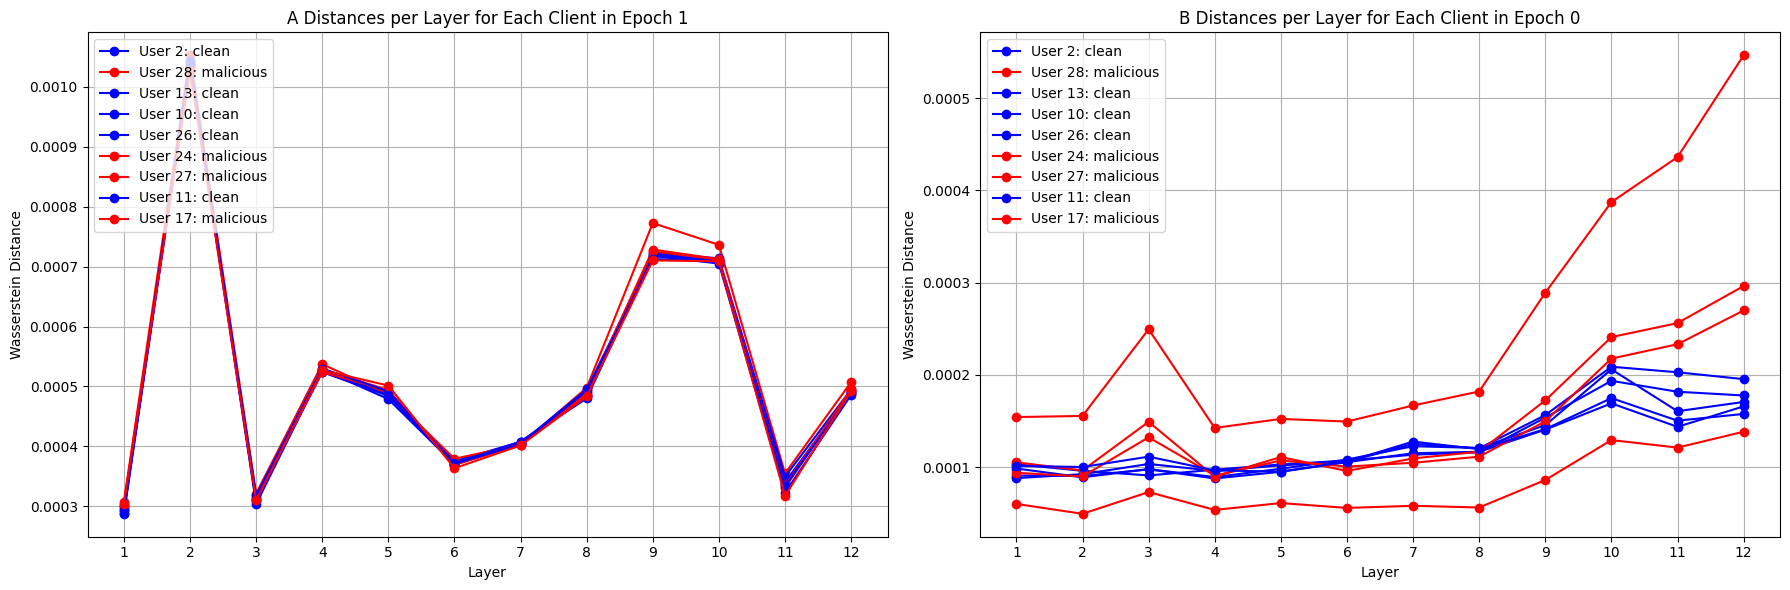

Epoch 2



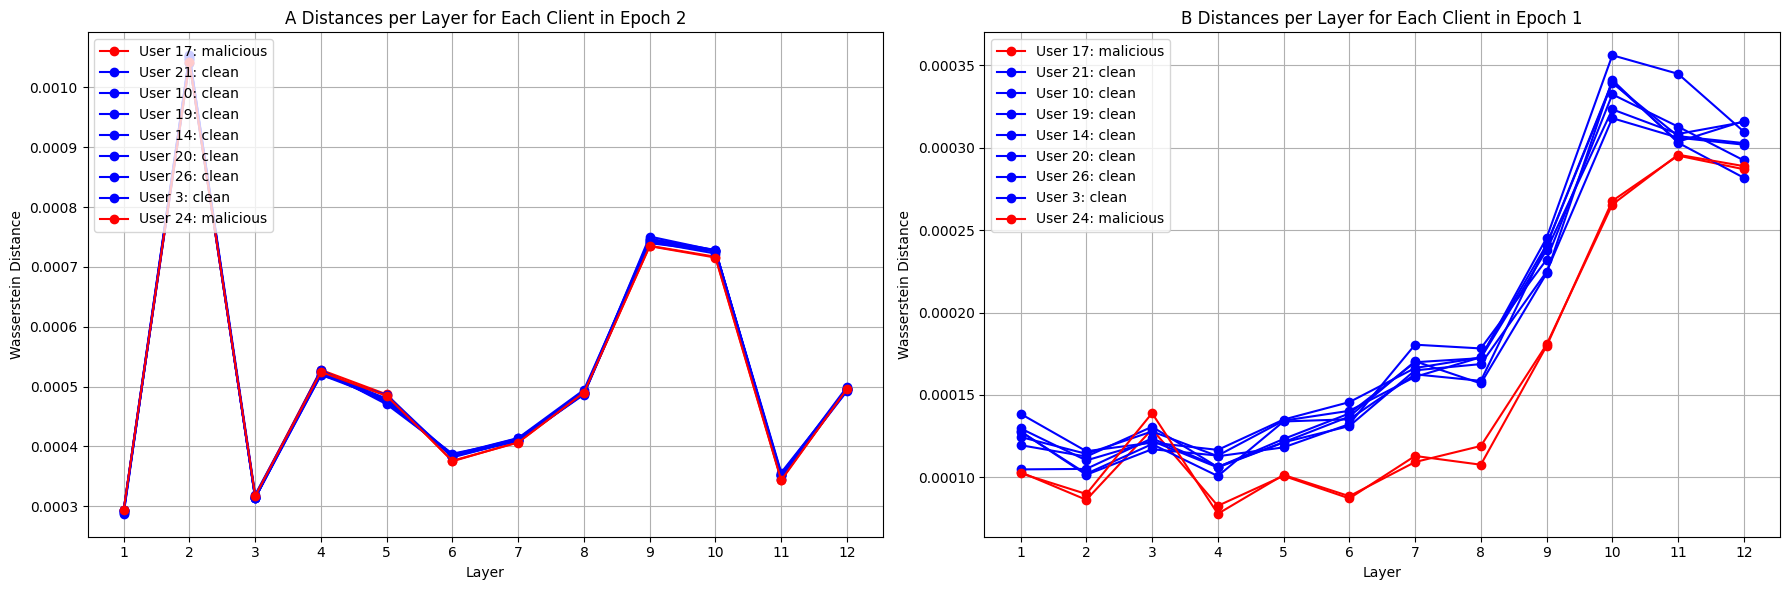

Epoch 3



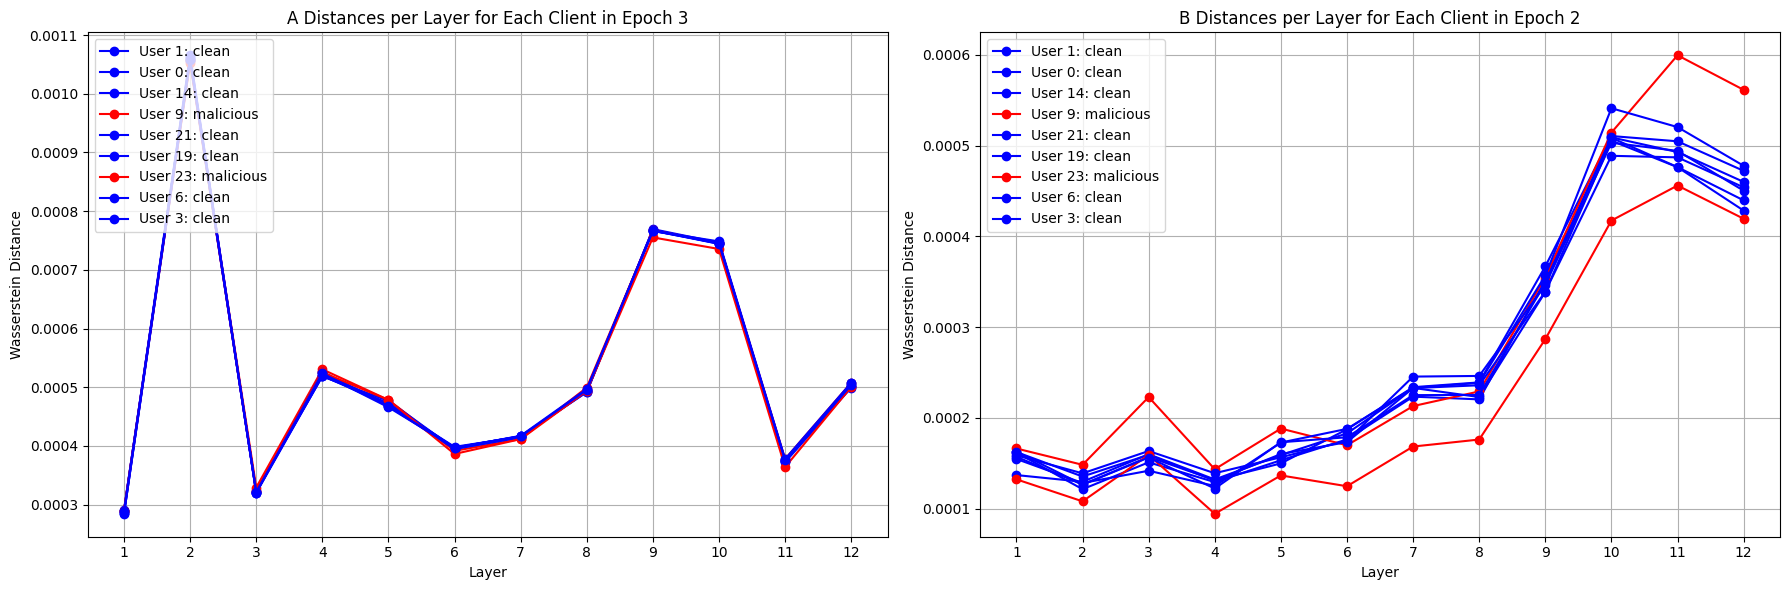

Epoch 4



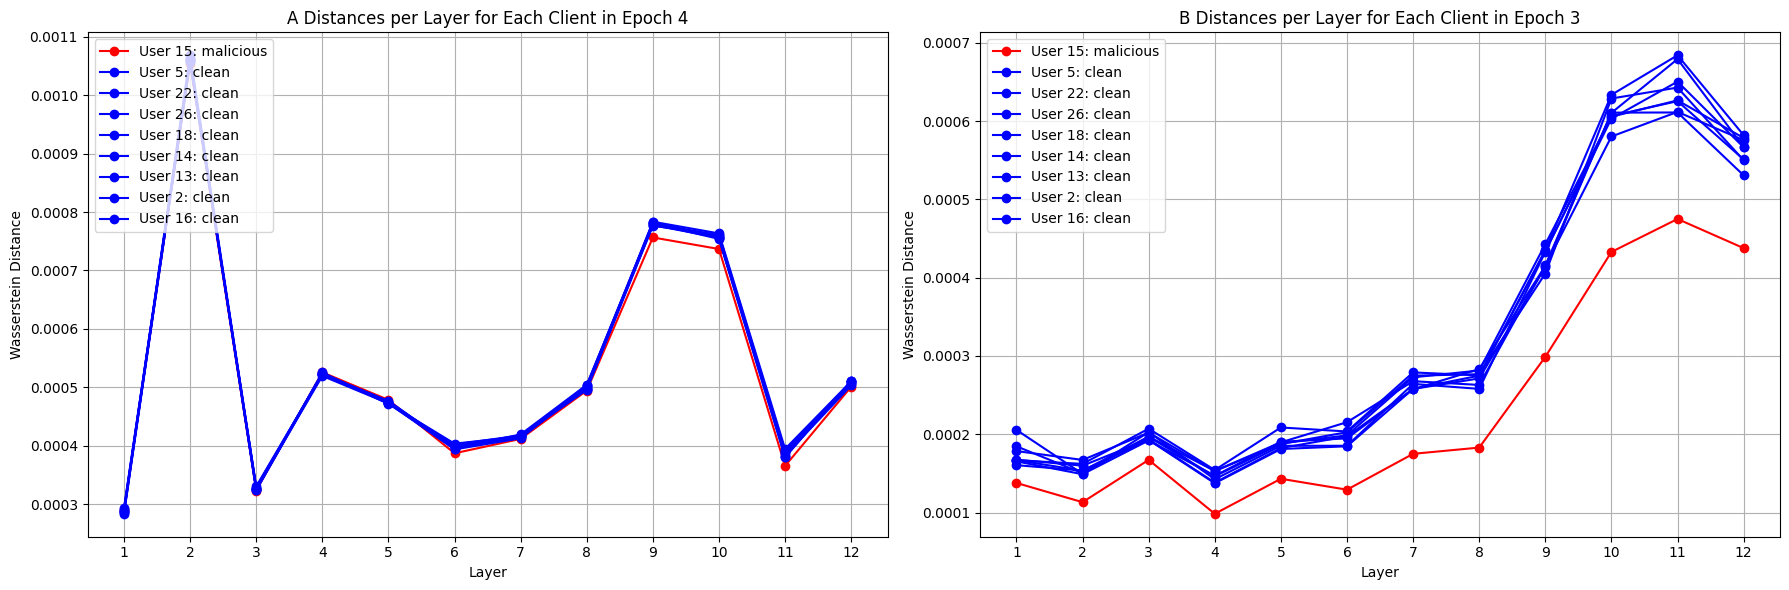

Epoch 5



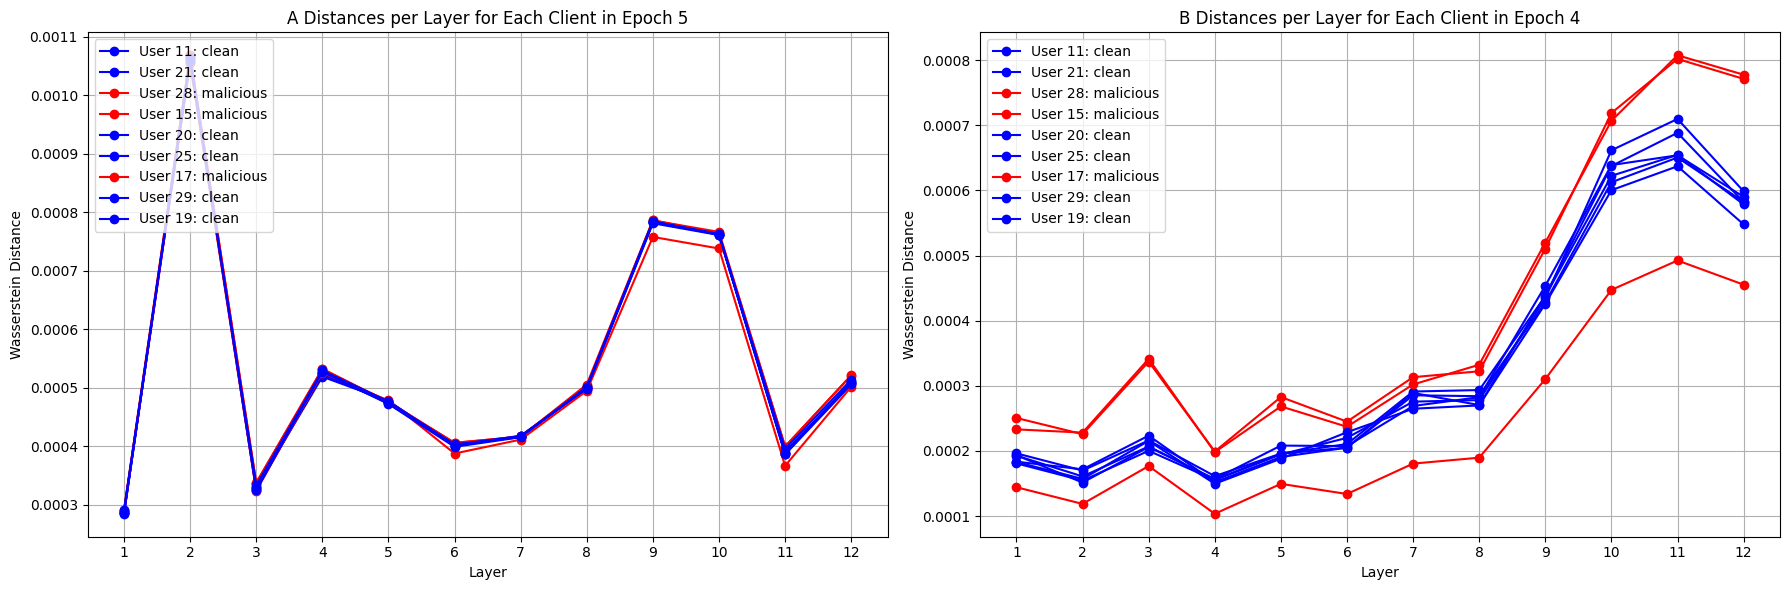

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors for the status
color_map = {
    'malicious': 'red',
    'clean': 'blue'
}

# Extract and visualize distances for each client per layer
for epoch in log.keys():
    print(f"Epoch {epoch + 1}\n")
    weights = []
    clients = []  # Keep track of client IDs and status for plotting

    for user in log[epoch].keys():
        if user != 'global':
            weights.append(log[epoch][user]['weights'])
            clients.append((user, log[epoch][user]['status']))
            # print(f'User {user}: {log[epoch][user]["status"]}')

    client_A_matrices, client_B_matrices = extract_lora_matrices(weights, num_layers=12)
    A_distances = compute_wa_distances(clean_A_matrices, client_A_matrices)
    B_distances = compute_wa_distances(clean_B_matrices, client_B_matrices)

    # print(f"A distances: {A_distances}")
    # print(f"B distances: {B_distances}")
    
    # Visualization of distances per layer side by side for A and B matrices
    num_layers = 12
    layers = np.arange(1, num_layers + 1)
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # Side-by-side plots

    # Plot A distances for each client
    for client_idx, (client_id, status) in enumerate(clients):
        client_A_distances = [A_distances[f'Layer_{i+1}'][client_idx] for i in range(num_layers)]
        axes[0].plot(layers, client_A_distances, marker='o', label=f'User {client_id}: {status}',
                     color=color_map[status])  # Use color based on status

    axes[0].set_title(f'A Distances per Layer for Each Client in Epoch {epoch + 1}')
    axes[0].set_xlabel('Layer')
    axes[0].set_ylabel('Wasserstein Distance')
    axes[0].set_xticks(layers)
    axes[0].legend(loc='upper left')
    axes[0].grid(True)

    # Plot B distances for each client
    for client_idx, (client_id, status) in enumerate(clients):
        client_B_distances = [B_distances[f'Layer_{i+1}'][client_idx] for i in range(num_layers)]
        axes[1].plot(layers, client_B_distances, marker='o', label=f'User {client_id}: {status}',
                     color=color_map[status])  # Use color based on status

    axes[1].set_title(f'B Distances per Layer for Each Client in Epoch {epoch}')
    axes[1].set_xlabel('Layer')
    axes[1].set_ylabel('Wasserstein Distance')
    axes[1].set_xticks(layers)
    axes[1].legend(loc='upper left')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    # break  # Remove this if you want to process multiple epochs

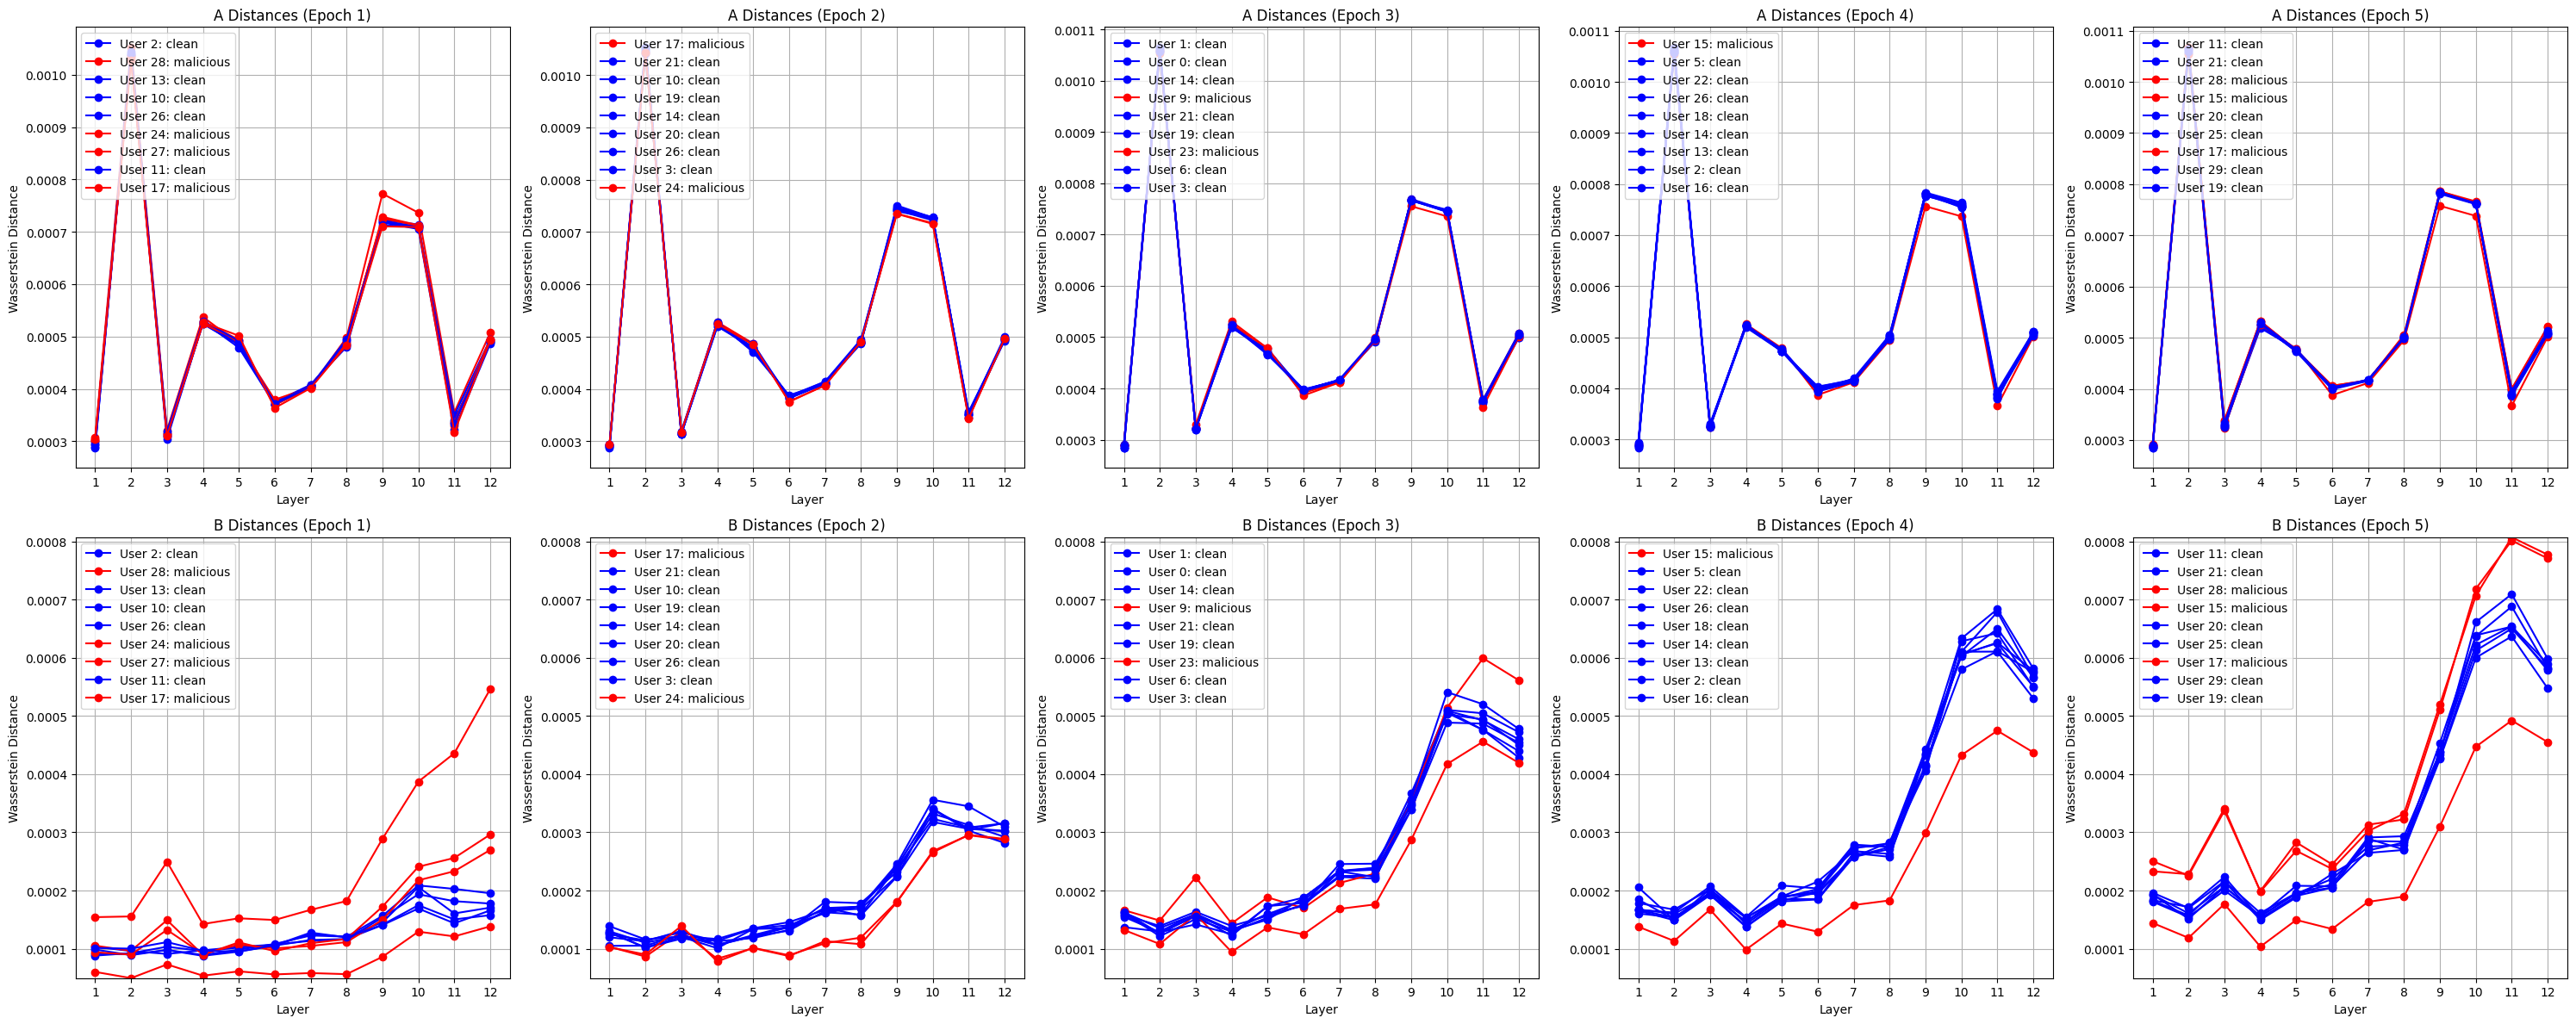

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors for the status
color_map = {
    'malicious': 'red',
    'clean': 'blue'
}

# Number of epochs
num_epochs = len(log.keys())

# Create a grid of subplots with A matrices on top and B matrices on the bottom
fig, axes = plt.subplots(2, num_epochs, figsize=(6 * num_epochs, 12))

# Determine the global y-axis range for B parameters
all_B_distances = []
for epoch in log.keys():
    weights = []
    for user in log[epoch].keys():
        if user != 'global':
            weights.append(log[epoch][user]['weights'])
    _, client_B_matrices = extract_lora_matrices(weights, num_layers=12)
    B_distances = compute_wa_distances(clean_B_matrices, client_B_matrices)
    for layer in range(12):
        all_B_distances.extend([B_distances[f'Layer_{layer + 1}'][client_idx] for client_idx in range(len(B_distances[f'Layer_{layer + 1}']))])

B_min, B_max = min(all_B_distances), max(all_B_distances)

for epoch_idx, epoch in enumerate(log.keys()):
    weights = []
    clients = []  # Keep track of client IDs and status for plotting

    for user in log[epoch].keys():
        if user != 'global':
            weights.append(log[epoch][user]['weights'])
            clients.append((user, log[epoch][user]['status']))

    client_A_matrices, client_B_matrices = extract_lora_matrices(weights, num_layers=12)
    A_distances = compute_wa_distances(clean_A_matrices, client_A_matrices)
    B_distances = compute_wa_distances(clean_B_matrices, client_B_matrices)

    num_layers = 12
    layers = np.arange(1, num_layers + 1)

    # Plot A distances for each client in the top row
    for client_idx, (client_id, status) in enumerate(clients):
        client_A_distances = [A_distances[f'Layer_{i+1}'][client_idx] for i in range(num_layers)]
        axes[0, epoch_idx].plot(layers, client_A_distances, marker='o', label=f'User {client_id}: {status}',
                                color=color_map[status])  # Use color based on status

    axes[0, epoch_idx].set_title(f'A Distances (Epoch {epoch + 1})')
    axes[0, epoch_idx].set_xlabel('Layer')
    axes[0, epoch_idx].set_ylabel('Wasserstein Distance')
    axes[0, epoch_idx].set_xticks(layers)
    axes[0, epoch_idx].legend(loc='upper left')
    axes[0, epoch_idx].grid(True)

    # Plot B distances for each client in the bottom row
    for client_idx, (client_id, status) in enumerate(clients):
        client_B_distances = [B_distances[f'Layer_{i+1}'][client_idx] for i in range(num_layers)]
        axes[1, epoch_idx].plot(layers, client_B_distances, marker='o', label=f'User {client_id}: {status}',
                                color=color_map[status])  # Use color based on status

    axes[1, epoch_idx].set_title(f'B Distances (Epoch {epoch + 1})')
    axes[1, epoch_idx].set_xlabel('Layer')
    axes[1, epoch_idx].set_ylabel('Wasserstein Distance')
    axes[1, epoch_idx].set_xticks(layers)
    axes[1, epoch_idx].legend(loc='upper left')
    axes[1, epoch_idx].grid(True)
    axes[1, epoch_idx].set_ylim(B_min, B_max)  # Align y-axis for B parameters

plt.tight_layout()
plt.show()

In [37]:
fig.savefig('figures/pilot_experiment.pdf')

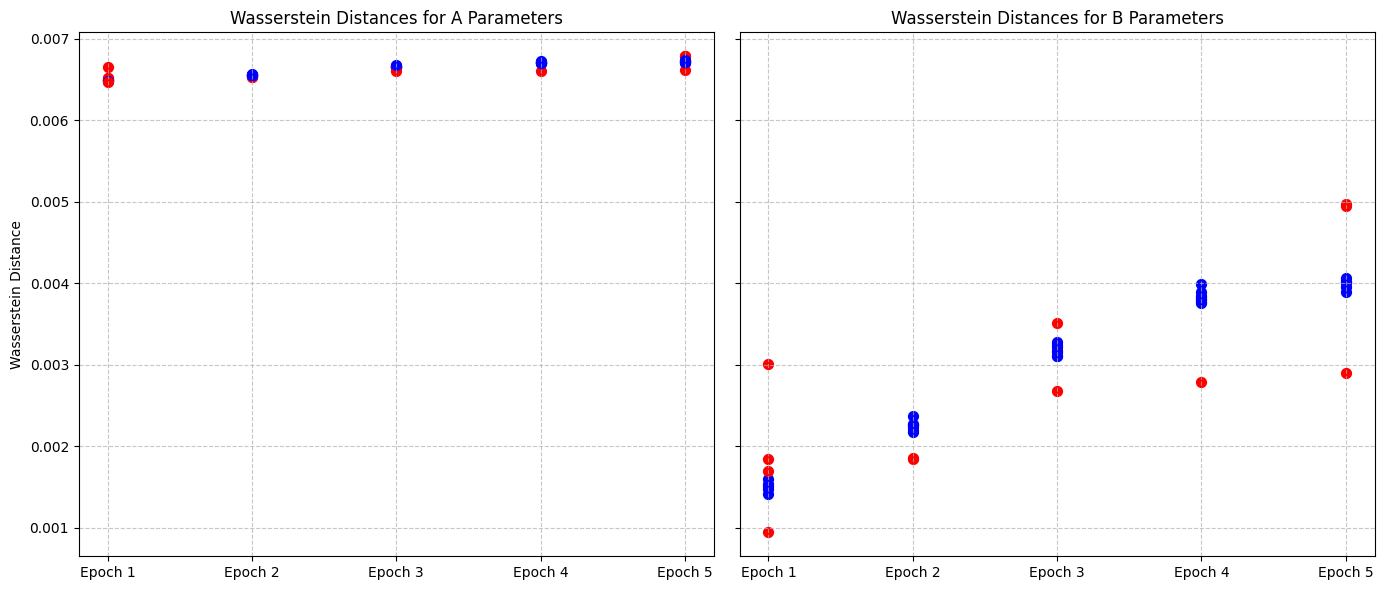

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors for the status
color_map = {
    'malicious': 'red',
    'clean': 'blue'
}

# Initialize data for plotting
all_epochs = list(log.keys())
client_distances = {}

# Calculate distances for all clients across epochs
for epoch_idx, epoch in enumerate(all_epochs):
    weights = []
    clients = []  # Keep track of client IDs and status for plotting

    for user in log[epoch].keys():
        if user != 'global':
            weights.append(log[epoch][user]['weights'])
            clients.append((user, log[epoch][user]['status']))

    # Extract matrices and compute distances
    client_A_matrices, client_B_matrices = extract_lora_matrices(weights, num_layers=12)
    A_distances = compute_wa_distances(clean_A_matrices, client_A_matrices)
    B_distances = compute_wa_distances(clean_B_matrices, client_B_matrices)

    for client_idx, (client_id, status) in enumerate(clients):
        total_A_distance = sum([A_distances[f'Layer_{i+1}'][client_idx] for i in range(12)])
        total_B_distance = sum([B_distances[f'Layer_{i+1}'][client_idx] for i in range(12)])

        if client_id not in client_distances:
            client_distances[client_id] = {
                'epochs': [],
                'A_distances': [],
                'B_distances': [],
                'status': status
            }

        client_distances[client_id]['epochs'].append(epoch_idx)
        client_distances[client_id]['A_distances'].append(total_A_distance)
        client_distances[client_id]['B_distances'].append(total_B_distance)

# Plot total distances for A and B matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot A-matrix distances
for client_id, client_data in client_distances.items():
    axes[0].scatter(
        client_data['epochs'],
        client_data['A_distances'],
        color=color_map[client_data['status']],
        s=50  # Dot size
    )
axes[0].set_title('Wasserstein Distances for A Parameters')
axes[0].set_ylabel('Wasserstein Distance')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot B-matrix distances
for client_id, client_data in client_distances.items():
    axes[1].scatter(
        client_data['epochs'],
        client_data['B_distances'],
        color=color_map[client_data['status']],
        s=50  # Dot size
    )
axes[1].set_title('Wasserstein Distances for B Parameters')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Add custom x-axis labels
for ax in axes:
    ax.set_xticks(range(len(all_epochs)))
    ax.set_xticklabels([f'Epoch {epoch+1}' for epoch in range(len(all_epochs))])

plt.tight_layout()
plt.show()

In [35]:
fig.savefig('figures/total_distance.pdf')

Epoch 0

[0, 12, 1, 0, 0, 5, 3, 1, 12]
[1.0, 42.569219381653056, 1.0, 1.0, 1.0, 12.180339887498949, 6.196152422706632, 2.0, -40.569219381653056]
Detected Outliers: [1, 5, 6, 8]


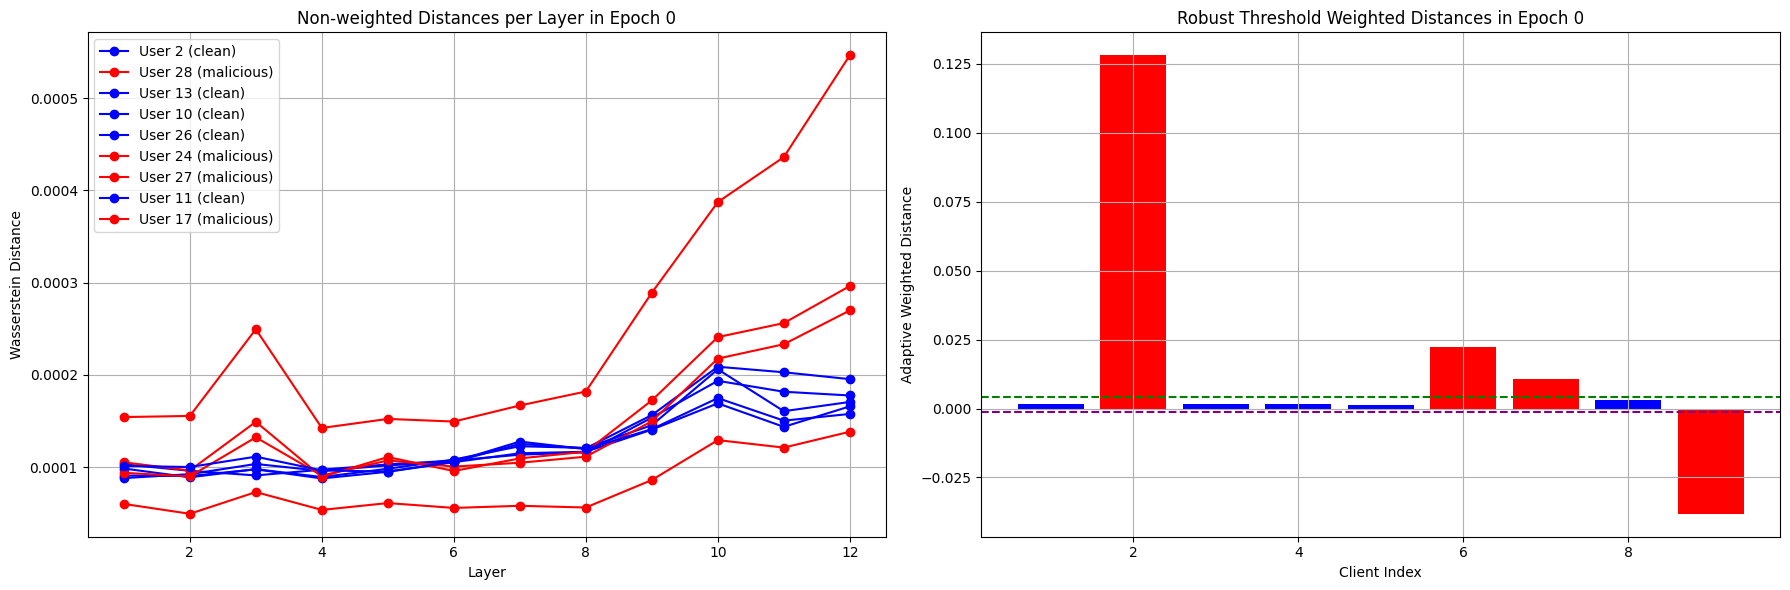

Epoch 1

[10, 2, 6, 1, 2, 1, 1, 0, 11]
[-30.622776601683793, 3.8284271247461903, 15.696938456699069, 1.0, -1.8284271247461903, 1.0, 2.0, 1.0, -35.4828726939094]
Detected Outliers: [0, 2, 8]


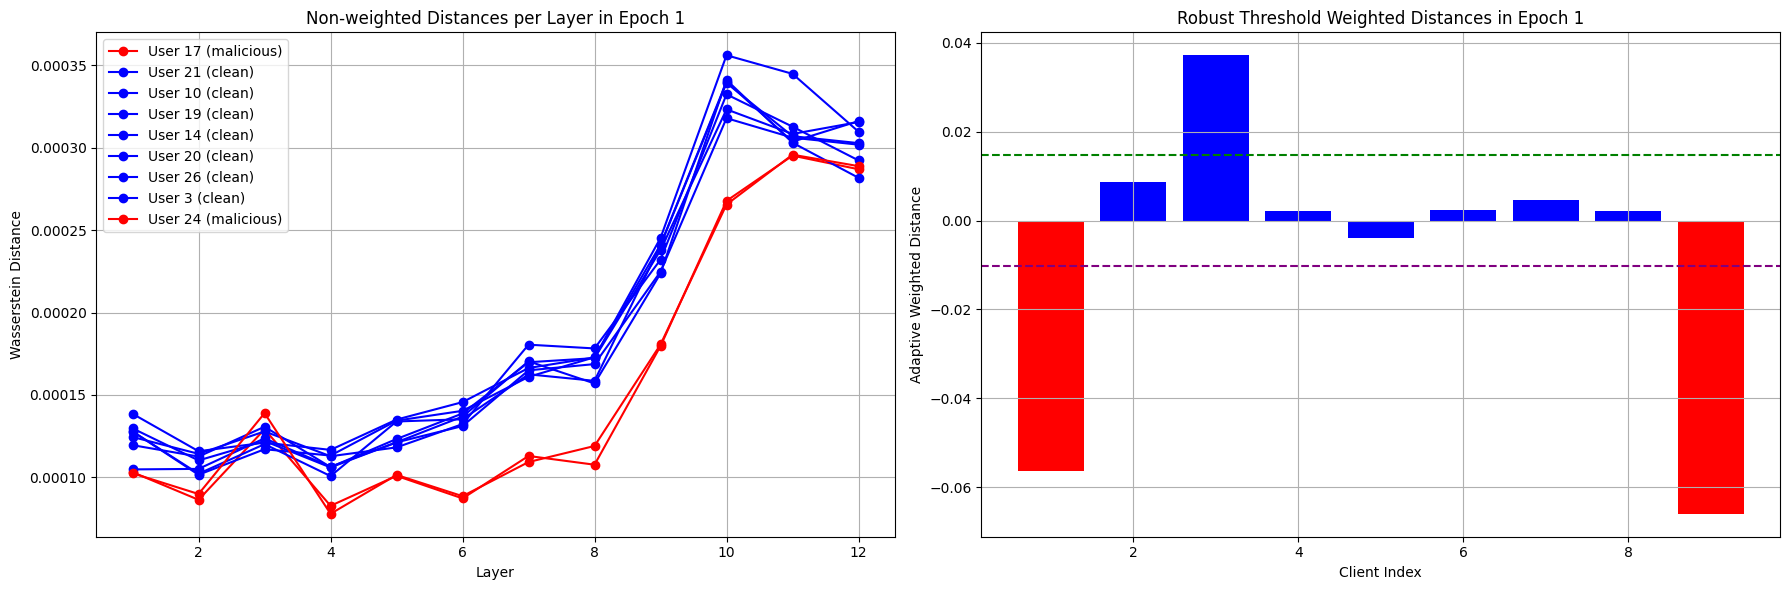

Epoch 2

[1, 2, 1, 8, 4, 1, 11, 4, 1]
[1.0, 3.8284271247461903, 1.0, 23.627416997969522, 9.0, 1.0, -35.4828726939094, 9.0, 2.0]
Detected Outliers: [3, 6, 7]


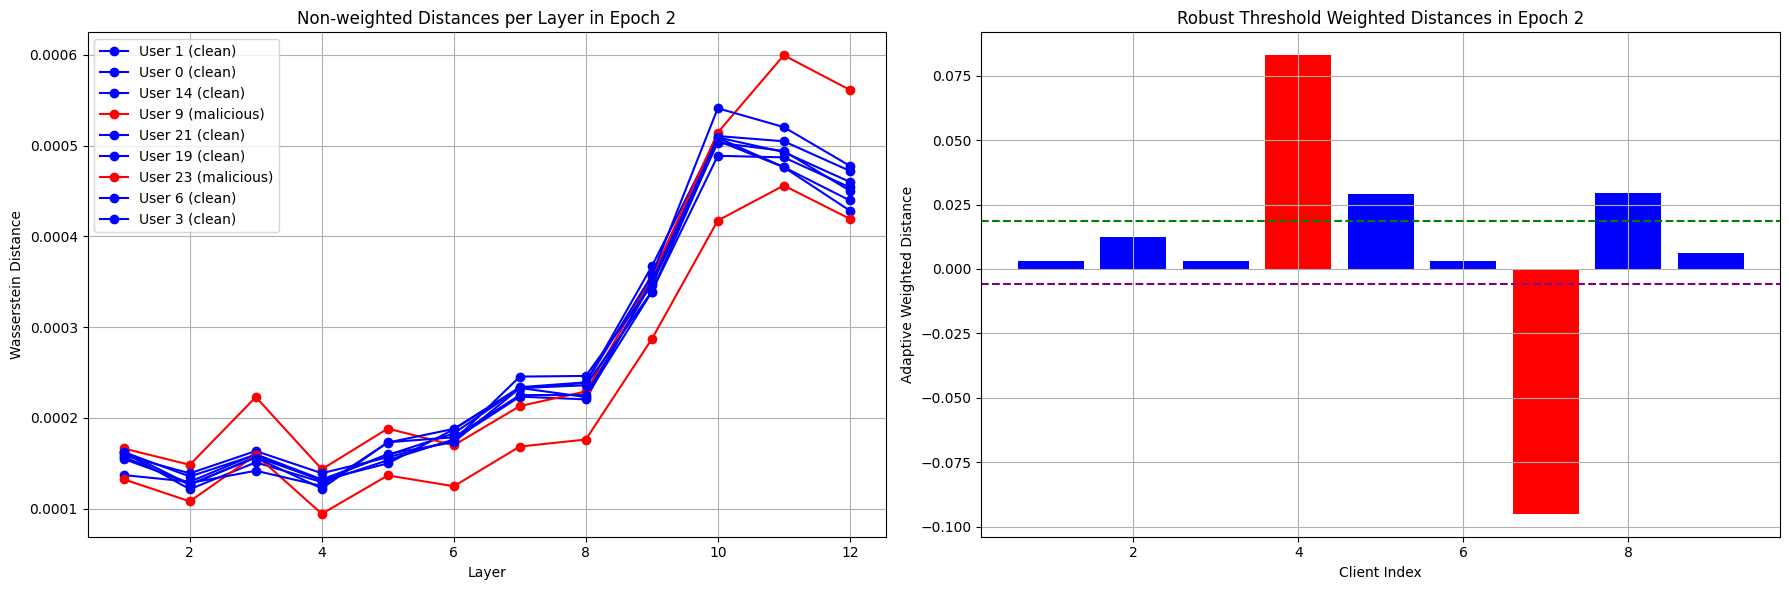

Epoch 3

[12, 2, 1, 3, 2, 3, 6, 3, 3]
[-40.569219381653056, -1.8284271247461903, 1.0, 6.196152422706632, 3.8284271247461903, -4.196152422706632, 15.696938456699069, 6.196152422706632, -4.196152422706632]
Detected Outliers: [0, 6]


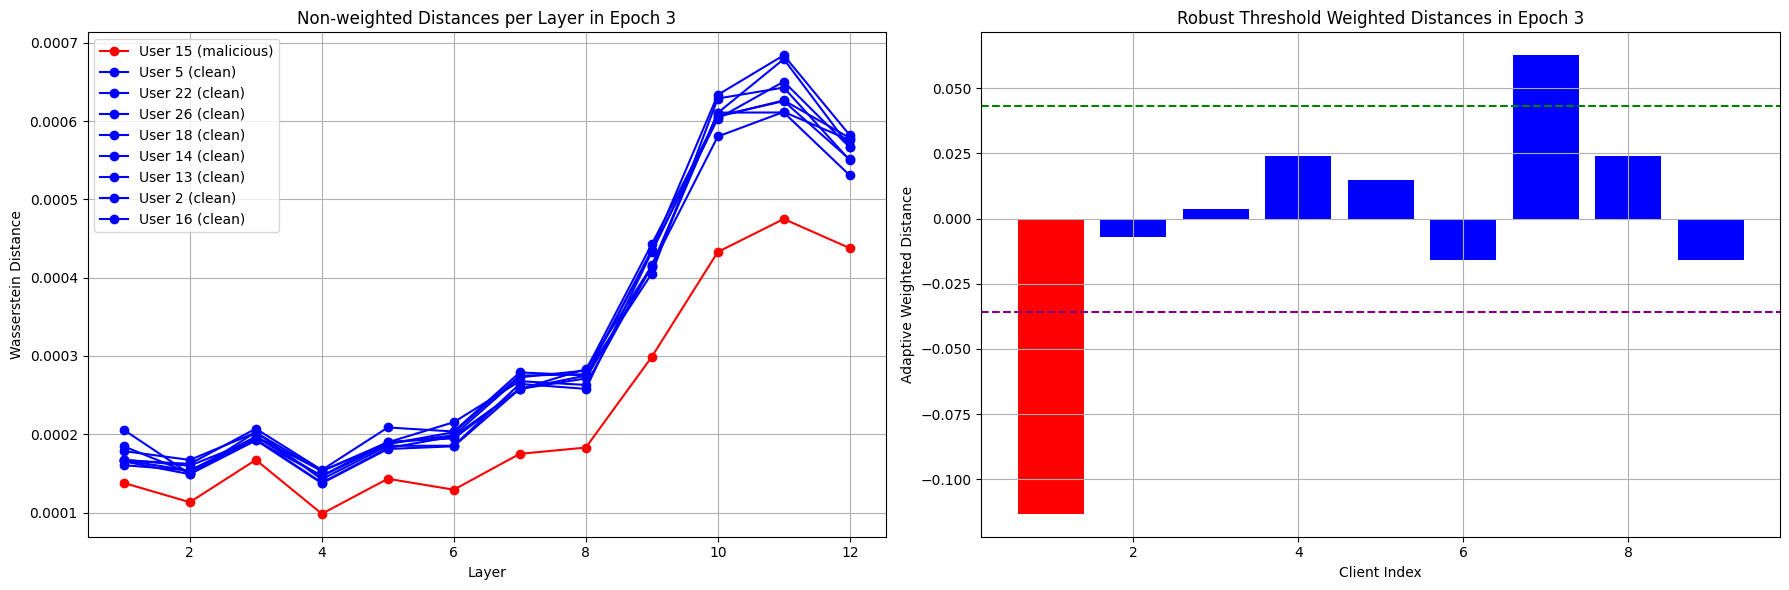

Epoch 4

[1, 0, 11, 12, 1, 2, 12, 1, 0]
[1.0, 1.0, 37.4828726939094, 42.569219381653056, 2.0, 3.8284271247461903, -40.569219381653056, 2.0, 1.0]
Detected Outliers: [0, 2, 3, 6]


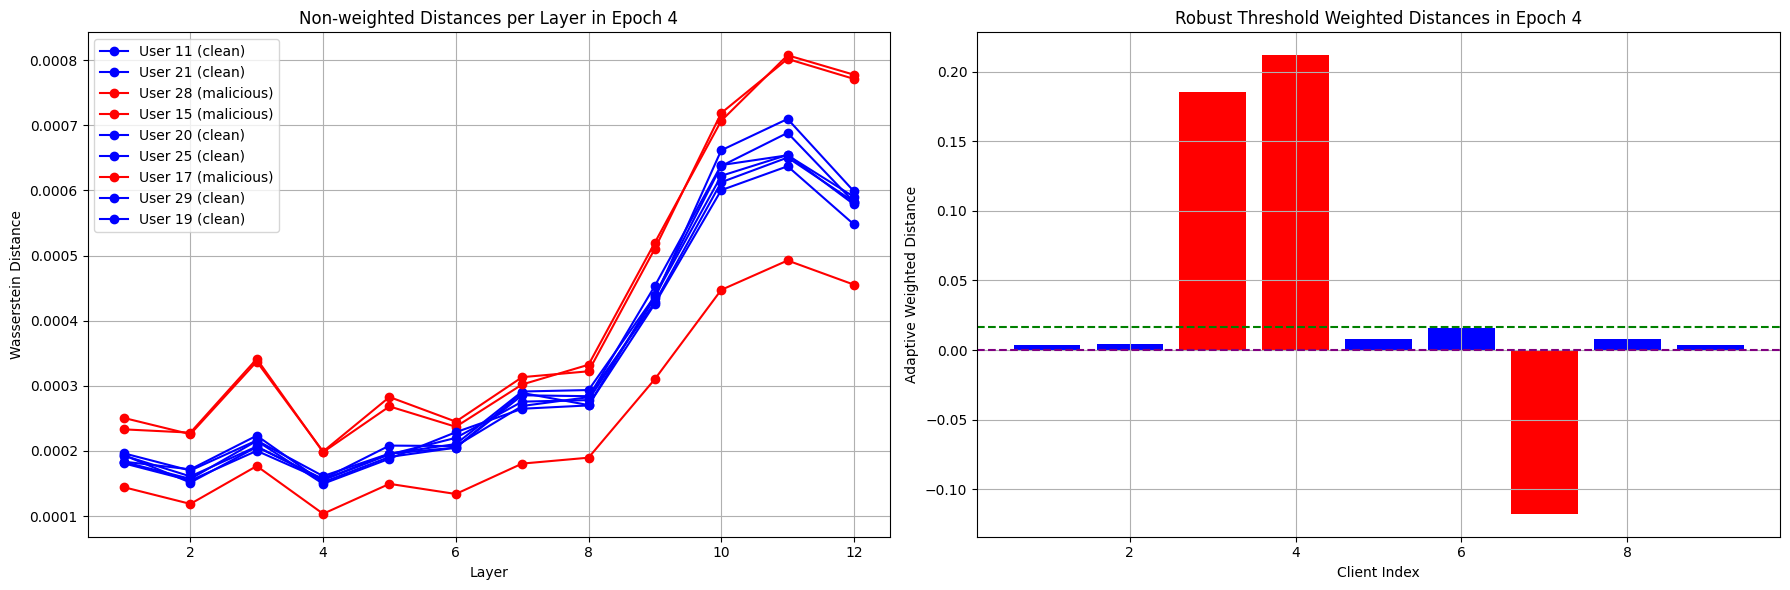

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute directional adaptive weights
def compute_adaptive_weights_directional(deviation_counts, deviation_directions, weight_factor=1, exponent=1.5, max_weight=3.0):
    adaptive_weights = []
    for count, direction in zip(deviation_counts, deviation_directions):
        amplification = weight_factor * (count ** exponent)
        # Adjust amplification direction
        if direction == -1:
            amplification = -amplification
        weight = 1 + amplification
        # weight = np.clip(weight, -max_weight, max_weight)
        if weight == 0:
            adaptive_weights.append(1.0)    
        else:
            adaptive_weights.append(weight)
    return adaptive_weights

# Function to calculate layer-wise thresholds and deviations
def calculate_layerwise_thresholds(distances, alpha=1.5):
    thresholds = {}
    deviation_counts = [0] * len(distances[next(iter(distances))])
    deviation_directions = [0] * len(distances[next(iter(distances))])

    for layer, layer_distances in distances.items():
        median = np.median(layer_distances)
        # std_dev = np.std(layer_distances)
        mad = np.median(np.abs(layer_distances - median))
        upper_threshold = median + alpha * mad
        lower_threshold = median - alpha * mad
        thresholds[layer] = (upper_threshold, lower_threshold)

        # Count deviations per client
        for i, distance in enumerate(layer_distances):
            if distance > upper_threshold:
                deviation_counts[i] += 1
                deviation_directions[i] = 1
            elif distance < lower_threshold:
                deviation_counts[i] += 1
                deviation_directions[i] = -1

    return thresholds, deviation_counts, deviation_directions

# Function to compute weighted distances using variance-based attention
def compute_weighted_distance_with_attention(distances, layer_variances):
    num_clients = len(distances[next(iter(distances))])
    weighted_distances = [0.0] * num_clients
    attention_weights = {layer: np.exp(var) for layer, var in layer_variances.items()}
    attention_sum = sum(attention_weights.values())
    normalized_attention = {layer: weight / attention_sum for layer, weight in attention_weights.items()}
    for layer_key, weight in normalized_attention.items():
        for i in range(num_clients):
            weighted_distances[i] += weight * distances[layer_key][i]
    return weighted_distances

# Function to apply adaptive weights to distances and compute the final weighted distance
def apply_adaptive_weights(distances, adaptive_weights):
    num_clients = len(distances[next(iter(distances))])
    adjusted_distances = [0.0] * num_clients

    # Sum distances for each client and apply adaptive weights
    for layer_key, layer_distances in distances.items():
        for i in range(num_clients):
            adjusted_distances[i] += layer_distances[i] * adaptive_weights[i]

    return adjusted_distances

def calculate_robust_thresholds(weighted_distances, alpha=2.0):
    """
    Calculate robust thresholds using median and MAD for weighted distances.
    :param weighted_distances: List of weighted distances for each client.
    :param alpha: Scaling factor for threshold adjustment.
    :return: A dictionary containing 'upper' and 'lower' thresholds.
    """
    median = np.median(weighted_distances)
    mad = np.median(np.abs(weighted_distances - median))
    upper_threshold = median + alpha * mad
    lower_threshold = median - alpha * mad
    return {'upper': upper_threshold, 'lower': lower_threshold}

def detect_anomalies_by_distance(distances, layer_variances, alpha=2.0, base_weight=1.0, weight_factor=0.1, exponent=1.5, max_weight=3.0):
    """ 
    Detect outlier clients based on adaptive weighted distances with robust thresholding.
    :param distances: Dictionary of layer-wise distances between clean model's matrices and client matrices.
    :param layer_variances: Dictionary of variances for each layer.
    :param alpha: Scaling factor for calculating MAD-based thresholds.
    :param base_weight: Base weight for adaptive weight calculation.
    :param weight_factor: Factor controlling how much the adaptive weights increase per deviation.
    :param exponent: Exponent applied to deviation count to amplify weights.
    :param max_weight: Maximum allowed weight for adaptive weighting.
    :return: List of indices of outlier clients.
    """
    outlier_clients = []

    thresholds, deviation_counts, deviation_directions = calculate_layerwise_thresholds(distances, alpha=alpha)

    adaptive_weights = compute_adaptive_weights_directional(deviation_counts, deviation_directions,
                                                            base_weight=base_weight, weight_factor=weight_factor,
                                                            exponent=exponent, max_weight=max_weight)

    attention_weights = {layer: np.exp(var) for layer, var in layer_variances.items()}
    attention_sum = sum(attention_weights.values())
    normalized_attention = {layer: weight / attention_sum for layer, weight in attention_weights.items()}

    weighted_distances = compute_weighted_distance_with_attention(distances, normalized_attention)

    weighted_distances_with_adaptive = [dist * adaptive_weights[i] for i, dist in enumerate(weighted_distances)]

    robust_thresholds = calculate_robust_thresholds(weighted_distances_with_adaptive, alpha=alpha)

    for i, distance in enumerate(weighted_distances_with_adaptive):
        if distance > robust_thresholds['upper'] or distance < robust_thresholds['lower']:
            outlier_clients.append(i)

    return outlier_clients


# Update the plotting function to use the robust threshold calculation
for epoch in log.keys():
    print(f"Epoch {epoch}\n")
    weights = []
    clients = []

    for user in log[epoch].keys():
        if user != 'global':
            weights.append(log[epoch][user]['weights'])
            clients.append((user, log[epoch][user]['status']))

    _, client_B_matrices = extract_lora_matrices(weights, num_layers=12)
    B_distances = compute_wa_distances(clean_B_matrices, client_B_matrices)

    # Calculate variance for each layer
    layer_variances = {layer: np.var(B_distances[layer]) for layer in B_distances.keys()}

    # Calculate adaptive weights based on deviations and directions
    thresholds, deviation_counts, deviation_directions = calculate_layerwise_thresholds(B_distances)
    adaptive_weights = compute_adaptive_weights_directional(deviation_counts, deviation_directions)
    
    print(deviation_counts)
    print(adaptive_weights)
    # Apply adaptive weights to distances
    weighted_distances_adaptive = apply_adaptive_weights(B_distances, adaptive_weights)

    # Calculate robust thresholds
    robust_thresholds = calculate_robust_thresholds(weighted_distances_adaptive)
    
    clean_state = log[epoch]['global']['weights']
    attackers = detect_outliers_from_weights(clean_state, weights)
    print(f"Detected Outliers: {attackers}")

    # Visualization
    num_layers = 12
    layers = np.arange(1, num_layers + 1)

    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    # Plot non-weighted distances per layer
    for client_idx, (client_id, status) in enumerate(clients):
        client_distances = [B_distances[f'Layer_{i+1}'][client_idx] for i in range(num_layers)]
        axs[0].plot(layers, client_distances, marker='o', label=f'User {client_id} ({status})', color=color_map[status])

    axs[0].set_title(f'Non-weighted Distances per Layer in Epoch {epoch}')
    axs[0].set_xlabel('Layer')
    axs[0].set_ylabel('Wasserstein Distance')
    axs[0].legend(loc='upper left')
    axs[0].grid(True)

    # Plot weighted distances using variance attention
    for client_idx, (client_id, status) in enumerate(clients):
        axs[1].bar(client_idx + 1, weighted_distances_adaptive[client_idx], color=color_map[status],
                   label=f'User {client_id} ({status})' if client_idx == 0 else "")

    # Add robust thresholds for weighted distances
    axs[1].axhline(robust_thresholds['upper'], color='green', linestyle='--', label='Upper Threshold')
    axs[1].axhline(robust_thresholds['lower'], color='purple', linestyle='--', label='Lower Threshold')
    axs[1].set_title(f'Robust Threshold Weighted Distances in Epoch {epoch}')
    axs[1].set_xlabel('Client Index')
    axs[1].set_ylabel('Adaptive Weighted Distance')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

Epoch 0

Proportional Deviation: {0: 0.0, 1: 7.768054464140518, 2: 0.0035604674171040747, 3: 0.0, 4: 0.0, 5: 0.8446459816762601, 6: 0.39884522613870305, 7: 0.02304826974642853, 8: 3.602487032219711}
Adaptive Weights: [1.0, 3.0, 1.000006338464114, 1.0, 1.0, 1.3567134171809265, 1.0795387572068167, 1.0002656113691522, 3.0]
Detected Outliers: [1, 5, 6, 8]


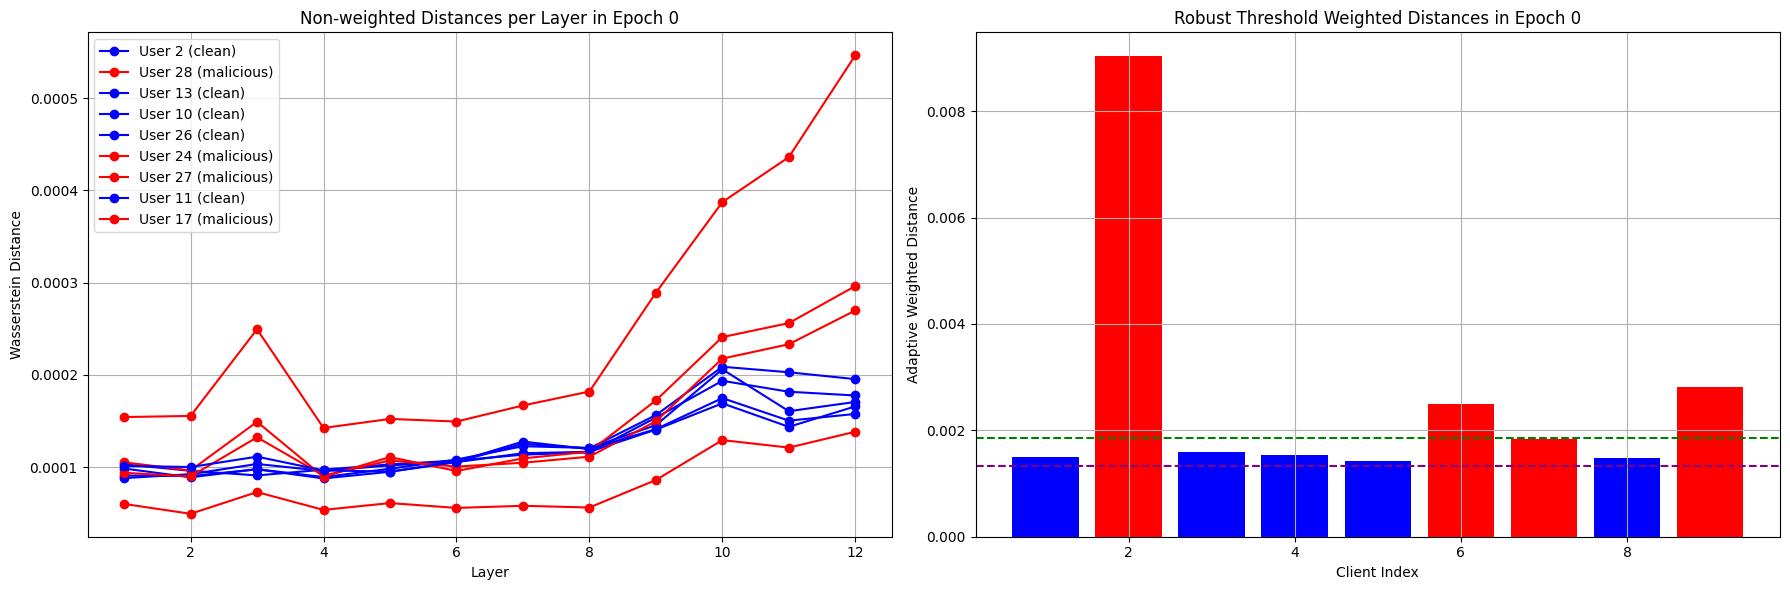

Epoch 1

Proportional Deviation: {0: 1.6218786474067626, 1: 0.0542275497024796, 2: 0.22114908842138647, 3: 0.002448635207862903, 4: 0.10339084317064477, 5: 0.002801345113598901, 6: 0.005739955668725588, 7: 0.0, 8: 1.6440744938157172}
Adaptive Weights: [2.3152451734569945, 1.0014703135733674, 1.0244534596548052, 1.0000029979071905, 1.0053448332257684, 1.0000039237672227, 1.0000164735455395, 1.0, 2.351490470607703]
Detected Outliers: [0, 2, 8]


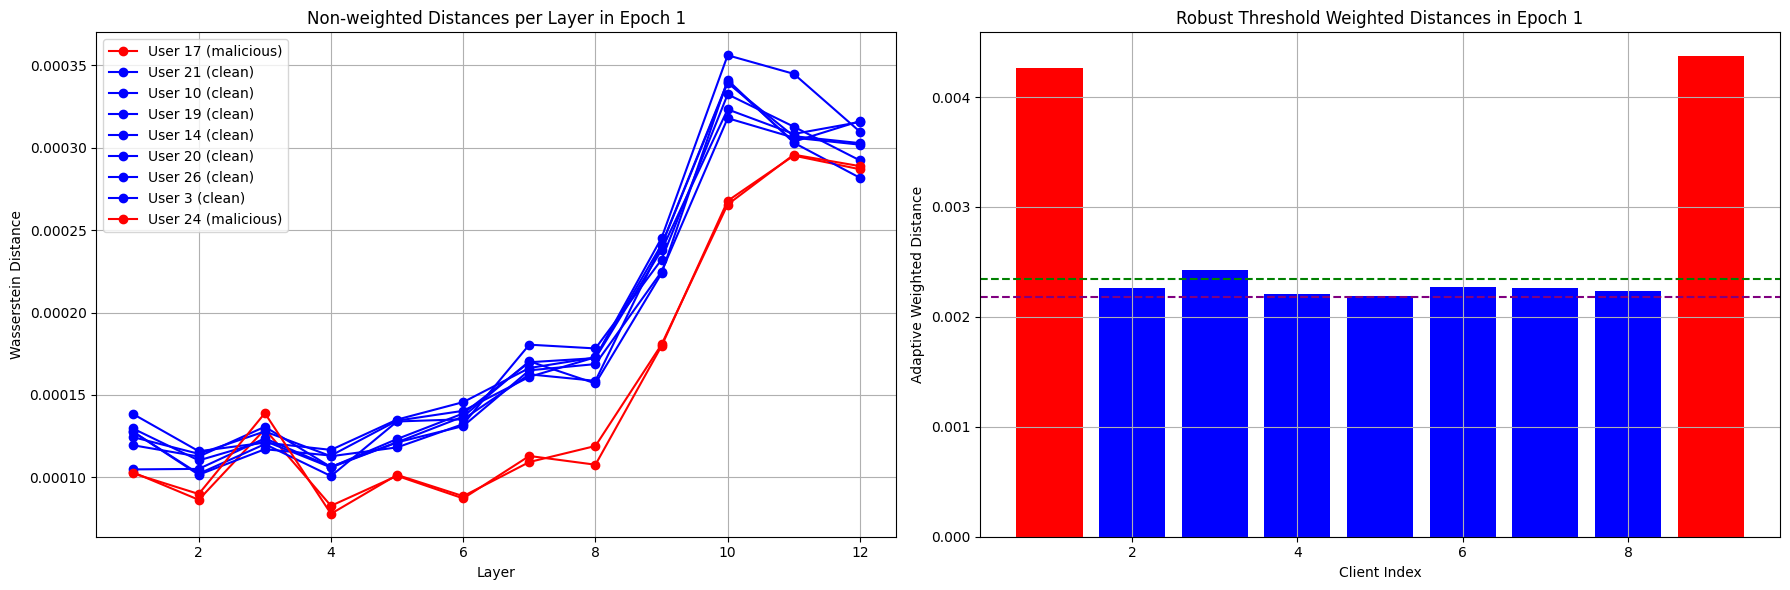

Epoch 2

Proportional Deviation: {0: 0.02479494986943561, 1: 0.024254226345183174, 2: 0.10322450803819352, 3: 0.9208623586204987, 4: 0.022701448441261565, 5: 0.023487755397549343, 6: 1.5351549732309633, 7: 0.14791439911356202, 8: 0.0014091447230010856}
Adaptive Weights: [1.0003073947695138, 1.0002941337478017, 1.0053276495298635, 1.4239937417620538, 1.0002576778806656, 1.0002758373268075, 2.17835039591788, 1.010939334732563, 1.0000009928444251]
Detected Outliers: [3, 6, 7]


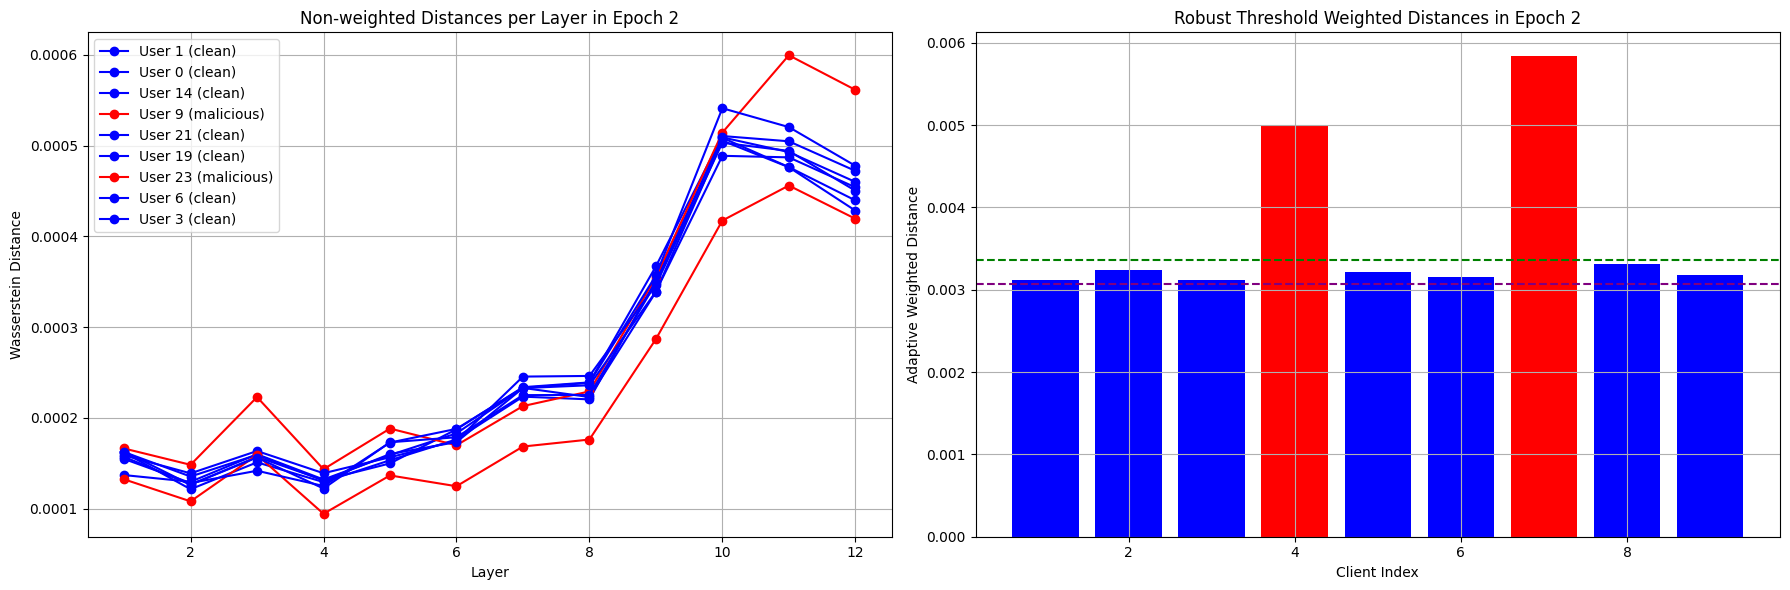

Epoch 3

Proportional Deviation: {0: 2.816890764453875, 1: 0.028074622682810642, 2: 0.03288329597579827, 3: 0.05830110568929447, 4: 0.048148833033669805, 5: 0.07337918432127115, 6: 0.2200614175641985, 7: 0.0728480233593481, 8: 0.20433245524166285}
Adaptive Weights: [3.0, 1.000394092219391, 1.000540655577116, 1.0016995094622971, 1.0011591550612522, 1.0026922523458275, 1.0242135137501822, 1.002653417253682, 1.0208758761325432]
Detected Outliers: [0, 6]


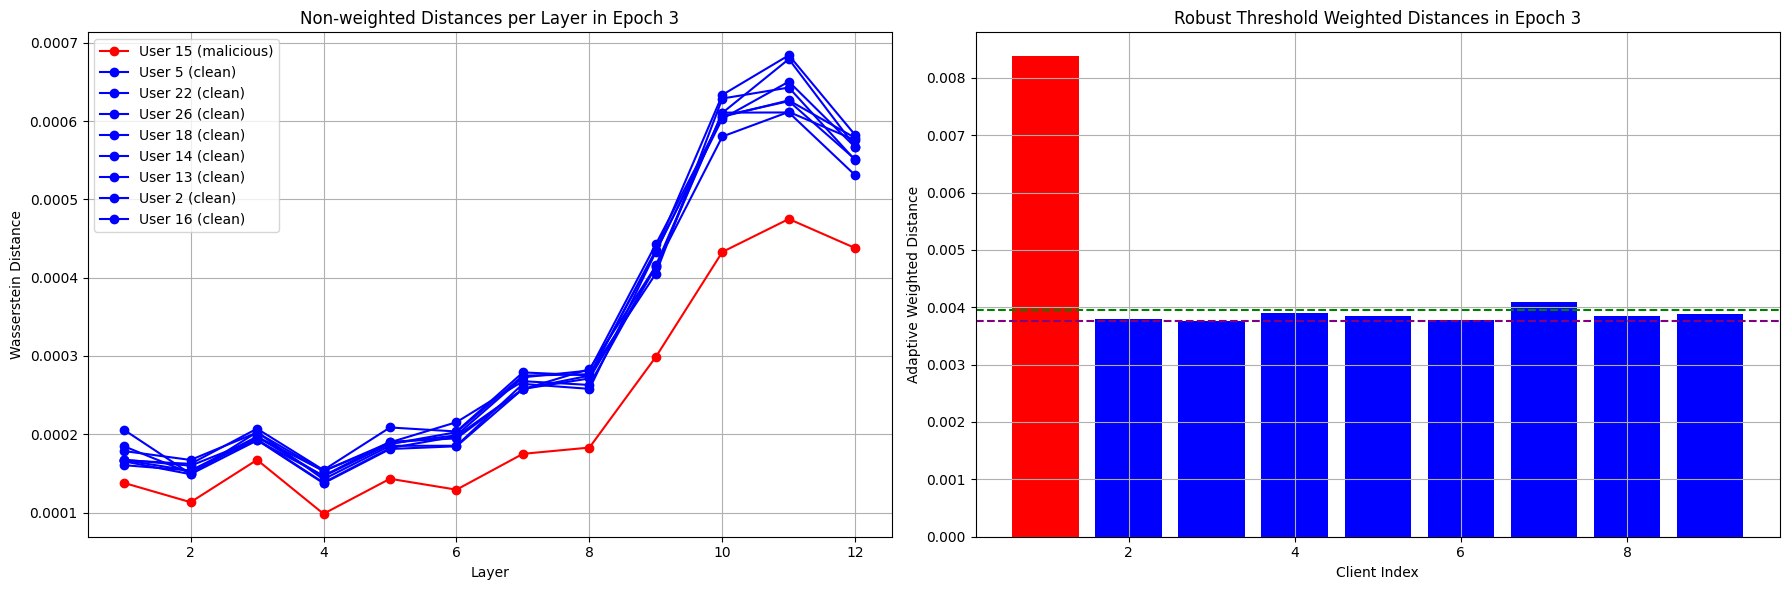

Epoch 4

Proportional Deviation: {0: 0.018787639111741854, 1: 0.0, 2: 2.19496211536765, 3: 2.3136320221625613, 4: 0.0057482258481235905, 5: 0.012329699789441307, 6: 2.7866866307429503, 7: 0.01745349504086442, 8: 0.0}
Adaptive Weights: [1.0001764876916965, 1.0, 3.0, 3.0, 1.0000165210502006, 1.000076010748449, 3.0, 1.0001523122445708, 1.0]
Detected Outliers: [0, 2, 3, 6]


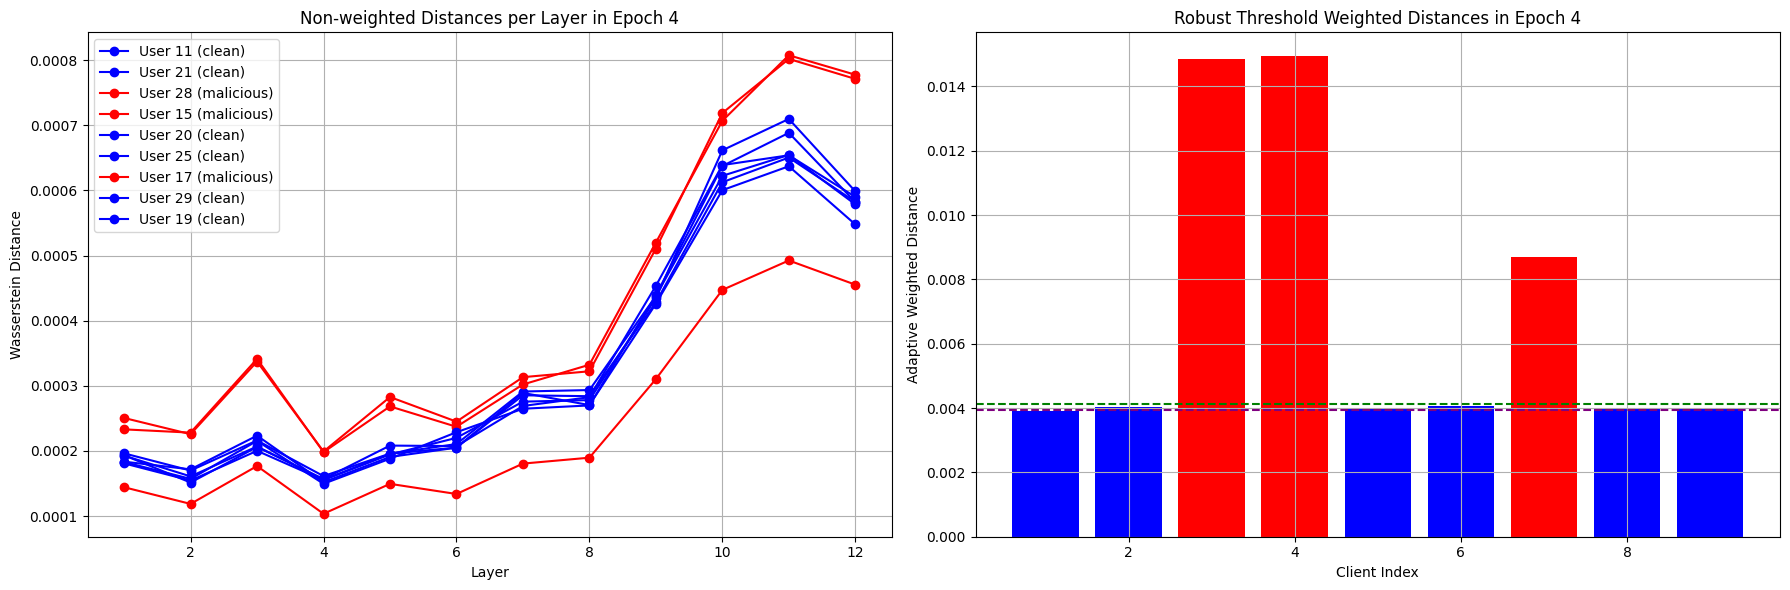

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate layer-wise thresholds and deviations
def calculate_layerwise_thresholds(distances, alpha=1.5):
    thresholds = {}
    proportional_deviation = {i: 0.0 for i in range(len(distances[next(iter(distances))]))}

    for layer, layer_distances in distances.items():
        median = np.median(layer_distances)
        mad = np.median(np.abs(layer_distances - median))
        upper_threshold = median + alpha * mad
        lower_threshold = median - alpha * mad
        thresholds[layer] = (upper_threshold, lower_threshold)

        # Calculate proportional deviations for each client
        for i, distance in enumerate(layer_distances):
            if distance > upper_threshold:
                proportional_deviation[i] += (distance - upper_threshold) / upper_threshold
            elif distance < lower_threshold:
                proportional_deviation[i] += (lower_threshold - distance) / lower_threshold

    return thresholds, proportional_deviation

# Function to compute proportional adaptive weights
def compute_adaptive_weights(proportional_deviation, weight_factor=1, exponent=2, max_weight=3.0):
    adaptive_weights = []
    for deviation in proportional_deviation.values():
        amplification = weight_factor * (deviation ** exponent)
        weight = 1 + amplification
        weight = np.clip(weight, -max_weight, max_weight)  # Clamping within range
        adaptive_weights.append(weight)
    return adaptive_weights

# Function to compute weighted distances using variance-based attention
def compute_weighted_distance_with_attention(distances, layer_variances):
    num_clients = len(distances[next(iter(distances))])
    weighted_distances = [0.0] * num_clients
    attention_weights = {layer: np.exp(var) for layer, var in layer_variances.items()}
    attention_sum = sum(attention_weights.values())
    normalized_attention = {layer: weight / attention_sum for layer, weight in attention_weights.items()}
    for layer_key, weight in normalized_attention.items():
        for i in range(num_clients):
            weighted_distances[i] += weight * distances[layer_key][i]
    return weighted_distances

# Function to apply adaptive weights to distances and compute the final weighted distance
def apply_adaptive_weights(distances, adaptive_weights):
    num_clients = len(distances[next(iter(distances))])
    adjusted_distances = [0.0] * num_clients

    # Sum distances for each client and apply adaptive weights
    for layer_key, layer_distances in distances.items():
        for i in range(num_clients):
            adjusted_distances[i] += layer_distances[i] * adaptive_weights[i]

    return adjusted_distances

def calculate_robust_thresholds(weighted_distances, alpha=1.5):
    """
    Calculate robust thresholds using median and MAD for weighted distances.
    """
    median = np.median(weighted_distances)
    mad = np.median(np.abs(weighted_distances - median))
    upper_threshold = median + alpha * mad
    lower_threshold = median - alpha * mad
    return {'upper': upper_threshold, 'lower': lower_threshold}

# Update the plotting function to use the new threshold calculation
for epoch in log.keys():
    print(f"Epoch {epoch}\n")
    weights = []
    clients = []

    for user in log[epoch].keys():
        if user != 'global':
            weights.append(log[epoch][user]['weights'])
            clients.append((user, log[epoch][user]['status']))

    _, client_B_matrices = extract_lora_matrices(weights, num_layers=12)
    B_distances = compute_wa_distances(clean_B_matrices, client_B_matrices)

    # Calculate variance for each layer
    layer_variances = {layer: np.var(B_distances[layer]) for layer in B_distances.keys()}

    # Calculate thresholds and proportional deviations
    thresholds, proportional_deviation = calculate_layerwise_thresholds(B_distances)

    # Compute adaptive weights
    adaptive_weights = compute_adaptive_weights(proportional_deviation)

    print("Proportional Deviation:", proportional_deviation)
    print("Adaptive Weights:", adaptive_weights)

    # Apply adaptive weights to distances
    weighted_distances_adaptive = apply_adaptive_weights(B_distances, adaptive_weights)

    # Calculate robust thresholds
    robust_thresholds = calculate_robust_thresholds(weighted_distances_adaptive)

    clean_state = log[epoch]['global']['weights']
    attackers = detect_outliers_from_weights(clean_state, weights)
    print(f"Detected Outliers: {attackers}")

    # Visualization
    num_layers = 12
    layers = np.arange(1, num_layers + 1)

    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    # Plot non-weighted distances per layer
    for client_idx, (client_id, status) in enumerate(clients):
        client_distances = [B_distances[f'Layer_{i+1}'][client_idx] for i in range(num_layers)]
        axs[0].plot(layers, client_distances, marker='o', label=f'User {client_id} ({status})', color=color_map[status])

    axs[0].set_title(f'Non-weighted Distances per Layer in Epoch {epoch}')
    axs[0].set_xlabel('Layer')
    axs[0].set_ylabel('Wasserstein Distance')
    axs[0].legend(loc='upper left')
    axs[0].grid(True)

    # Plot weighted distances using variance attention
    for client_idx, (client_id, status) in enumerate(clients):
        axs[1].bar(client_idx + 1, weighted_distances_adaptive[client_idx], color=color_map[status],
                   label=f'User {client_id} ({status})' if client_idx == 0 else "")

    # Add robust thresholds for weighted distances
    axs[1].axhline(robust_thresholds['upper'], color='green', linestyle='--', label='Upper Threshold')
    axs[1].axhline(robust_thresholds['lower'], color='purple', linestyle='--', label='Lower Threshold')
    axs[1].set_title(f'Robust Threshold Weighted Distances in Epoch {epoch}')
    axs[1].set_xlabel('Client Index')
    axs[1].set_ylabel('Adaptive Weighted Distance')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()